### Info
Plotting comparisons

In [1]:
import numpy as np
import pandas as pd

### Load data into a DataFrame

In [2]:
min_ind = 1
max_ind = 2

model_names = ('hls','qkeras','qonnx_init','qonnx_mod')
pred_all = []   # will be a list of arrays from each model

for model_name in model_names:
    pred_single = np.array([])
    for file_index in range(min_ind, max_ind+1):
        data = np.load('./pred_GluGluHToBB_M125/preds_'+model_name+str(file_index)+'.npy')
        pred_single = np.append(pred_single,data)
        #print(pred_single.shape)
    pred_all.append(pred_single)

pred_all = np.array(pred_all).T

In [3]:
pred_all.shape

(4096, 4)

In [4]:
df = pd.DataFrame(pred_all, columns=model_names)
df

,hls,qkeras,qonnx_init,qonnx_mod
0,950.750,947.250,947.250,945.750
1,127.750,126.250,126.250,125.500
2,1209.375,1205.750,1205.750,1203.625
3,252.500,250.750,250.750,249.750
4,439.375,437.500,437.500,438.250
...,...,...,...,...
4091,440.250,438.375,438.375,437.000
4092,367.750,365.625,365.625,366.000
4093,831.625,828.625,828.625,826.875
4094,1053.250,1049.750,1049.750,1050.750


### Compare predictions

In [5]:
df['qxinit_qkeras'] = np.abs(df['qonnx_init'] - df['qkeras'])
df['qxinit_qkeras'].value_counts()

qxinit_qkeras
0.0    4096
Name: count, dtype: int64

modified vs unmodified qonnx with respect to hls

In [6]:
df['qxinit_hls'] = np.abs(df['qonnx_init'] - df['hls'])
df['qxmod_hls'] = np.abs(df['qonnx_mod'] - df['hls'])

print(df['qxinit_hls'].value_counts())
print(df['qxmod_hls'].value_counts())

qxinit_hls
2.250    244
2.125    219
2.625    218
1.875    209
2.500    207
2.000    190
1.750    182
2.375    181
2.875    175
1.625    167
3.000    158
2.750    151
3.250    140
3.125    124
1.500    119
3.375    116
3.500    113
1.375    107
1.250     92
3.875     88
3.750     86
3.625     85
4.125     65
4.000     65
4.375     60
1.125     56
1.000     55
4.500     47
4.250     45
4.625     38
0.875     35
4.875     29
4.750     29
5.250     22
5.000     20
5.125     19
5.500     17
5.375     16
0.750     14
0.625     13
5.750      9
5.875      8
5.625      7
6.750      7
0.500      7
6.500      6
0.375      5
6.875      5
6.625      4
6.125      4
7.000      3
6.250      3
6.000      3
0.000      2
6.375      2
0.125      2
7.500      2
9.000      1
Name: count, dtype: int64
qxmod_hls
1.250     206
1.500     205
1.750     199
2.000     191
2.250     181
         ... 
9.750       1
10.000      1
10.125      1
10.625      1
10.500      1
Name: count, Length: 83, dtype: int64


### Create histograms

In [7]:
import matplotlib.pyplot as plt

In [8]:
dfpl = pd.DataFrame([df['qxinit_hls'].value_counts(),df['qxmod_hls'].value_counts()])
dfpl = dfpl.transpose()
dfpl.columns = ['init','mod']
dfpl = dfpl.fillna(0)
dfpl /= dfpl['init'].sum()  # percentage
dfpl *= 100
dfpl = dfpl.sort_index()
dfpl

,init,mod
0.000,0.048828,0.000000
0.125,0.048828,0.073242
0.250,0.000000,0.219727
0.375,0.122070,0.122070
0.500,0.170898,0.415039
...,...,...
10.250,0.000000,0.122070
10.375,0.000000,0.048828
10.500,0.000000,0.024414
10.625,0.000000,0.024414


In [9]:
def categ(x):
    if x==0.0 : return '0.0'
    if x < 1. : return '0 - 1'
    if x < 5. : return '1 - 5'
    if x < 10. : return '5 - 10'
    if x < 15. : return '10 - 15'
    return 'more'

In [10]:
# Categorize differences (deviations from hls preds)
dfpl['cat'] = dfpl.index.map(categ)

catdf = dfpl.groupby('cat').sum()
catdf

,init,mod
cat,,
0 - 1,1.855469,4.809570
0.0,0.048828,0.000000
1 - 5,94.238281,83.618164
10 - 15,0.000000,0.292969
5 - 10,3.857422,11.279297


In [11]:
catdf = catdf.reindex(['0.0','0 - 1','1 - 5','5 - 10','10 - 15'])
catdf

,init,mod
cat,,
0.0,0.048828,0.000000
0 - 1,1.855469,4.809570
1 - 5,94.238281,83.618164
5 - 10,3.857422,11.279297
10 - 15,0.000000,0.292969


Text(0.5, 1.0, 'Signal (ggH_to_BB_M-125)')

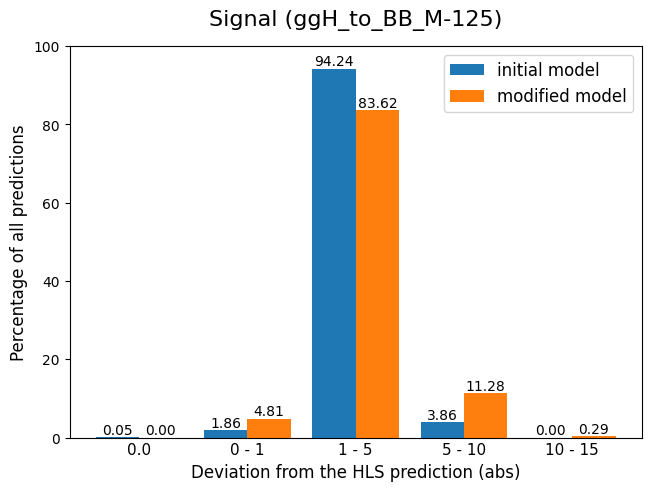

In [12]:
fig, ax = plt.subplots(layout='constrained')
width = 0.4
xticks = np.arange(catdf.shape[0])

labels = ["initial model","modified model"]

for i in range(len(catdf.keys())):
    b = ax.bar(xticks+(-1+i)*width, catdf.values[:,i], width, label=labels[i], align='edge')
    ax.bar_label(b, fmt='{:.2f}')

ax.legend(fontsize = 12)
ax.set_xticks(xticks)
ax.set_xticklabels(catdf.index.to_list(),fontdict={'size': 11})
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel("Deviation from the HLS prediction (abs)",{'size': 12})
ax.set_ylim(0,100)
ax.set_ylabel("Percentage of all predictions",{'size': 12})
ax.set_title("Signal (ggH_to_BB_M-125)",fontdict={'size': 16},pad=15)


In [13]:
fig.savefig('GluGlu.pdf')